In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import hddCRP.behaviorDataHandlers
import seaborn
import pandas as pd

file = open('Results/sequentialModel/Subject_A1_context_1_run_0.pkl', 'rb')
results1 = pickle.load(file)
file.close()

file = open('Results/sequentialModel/Subject_A1_context_2_run_0.pkl', 'rb')
results2 = pickle.load(file)
file.close()


In [7]:
contexts1 = results1["samples"]["transition_probabilities"]["contexts"];
contexts2 = results2["samples"]["transition_probabilities"]["contexts"];
tps1 = results1["samples"]["transition_probabilities"]["probabilities"][results1["MCMC_info"]["num_warmup_samples"]:,:,:,:];
tps2 = results2["samples"]["transition_probabilities"]["probabilities"][results2["MCMC_info"]["num_warmup_samples"]:,:,:,:];
divs, cs, short_context_indices = hddCRP.behaviorDataHandlers.compute_kl_diveregences_between_transition_probabilities(probs_1=tps1, probs_2=tps2, contexts_1=contexts1, contexts_2=contexts2)
divs = divs.squeeze()

tps2 = tps2.squeeze()
tps1 = tps1.squeeze()


In [4]:
context_names = [str(cn[1]) for cn in cs]

KL_deep_shallow = pd.DataFrame(divs[:,0,:].squeeze(), columns=context_names)
KL_shallow_deep = pd.DataFrame(divs[:,1,:].squeeze(), columns=context_names)
JS_deep_shallow = pd.DataFrame(divs[:,2,:].squeeze(), columns=context_names)

[Text(0.5, 1.0, 'KL(p(y | 2-back) || p(y | 1-back))')]

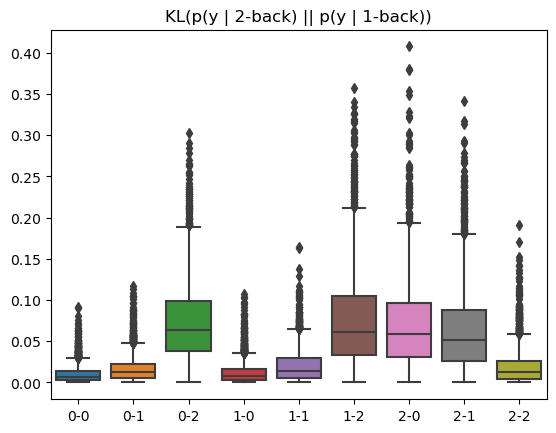

In [5]:
seaborn.boxplot(KL_deep_shallow).set(title="KL(p(y | 2-back) || p(y | 1-back))")

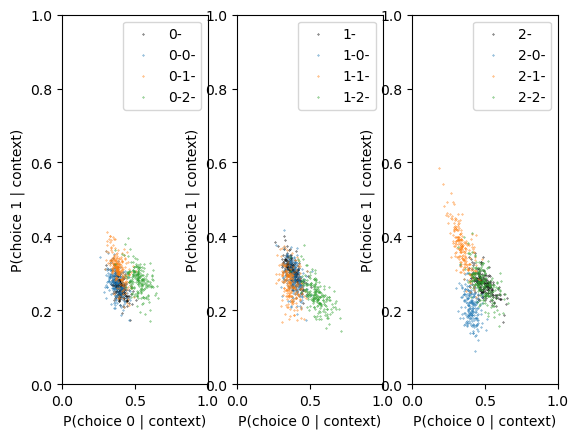

In [27]:
num_contexts = len(short_context_indices)
num_shallow_contexts = np.unique(short_context_indices).size;

shallow_context_found = np.zeros((num_shallow_contexts), dtype=bool)

for ii in range(num_shallow_contexts):
    ax = plt.subplot(1,num_shallow_contexts,ii+1)

    plt.scatter(tps1[::10, 0, ii], tps1[::10, 1, ii], s=0.1, color=[0,0,0])

    legend_items = [contexts1[ii]]

    two_backs = np.where(short_context_indices == ii)[0]
    for jj in two_backs:
        plt.scatter(tps2[::10, 0, jj], tps2[::10, 1, jj], s=0.1)
        legend_items += [contexts2[jj]]

    plt.legend(legend_items)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel("P(choice 0 | context)")
    plt.ylabel("P(choice 1 | context)")